In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
import re
import tensorflow_hub as hub

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gsevr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('IMDB dataset.csv')
# df['content'] = df.content.astype(str)
# df['sentiment'] = df.sentiment.astype(str)
# df['sentiment'] = df.sentiment.apply(lambda x: 'negative' if x == 'empty' or x == 'sadness' or x == 'worry' or x == 'hate' or x == 'boredom' or x == 'anger' \
#                         else 'neutral' if x == 'neutral' \
#                             else 'positive')


In [3]:
df.sentiment.unique()

array(['positive', 'negative'], dtype=object)

In [4]:
df['review'] = df.review.apply(lambda x: re.sub(r'@[^ ]*',r'',x))


def preprocess(text):
    t = text.lower()
    # t = re.sub('_',r'',t)
    # t = re.sub('\d+',r'',t)
    t = re.sub(r'@[^ ]*',r'',t)
    t = re.sub(r'\W+',r' ',t)
    t = re.sub(r'(https|quot|http)', '', t)
    t = re.sub(r'\b(?!(?:ai)\b)\w{3}\b','', t)
    t = re.sub(r'http?://\S+|www\.\S+','',t)
    stopwords_list = stopwords.words('english')
    txt = ' '.join([word for word in t.split() if word not in stopwords_list])
    return txt

lemmatizer = WordNetLemmatizer()



df['prepro'] = [' '.join([lemmatizer.lemmatize(preprocess(email))])
                 .strip() for email in df['review']]


texts = df.prepro.values
labels = df.sentiment.values


In [5]:
ohe = OneHotEncoder()
labels = ohe.fit_transform(df.sentiment.to_numpy().reshape(-1,1)).toarray()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels,test_size=0.25)

In [7]:
from gensim.models import KeyedVectors

# Load GloVe embeddings (50-dimensional vectors in this example)
glove_path = 'glove.6B.300d.txt'
word_vectors = KeyedVectors.load_word2vec_format(glove_path, binary=False, encoding='utf8',no_header=True)


In [8]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)

from keras.preprocessing.sequence import pad_sequences

max_sequence_length = 100  # Set your desired sequence length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')


from keras.layers import Embedding

embedding_dim = 300  # Use the same dimension as your pretrained embeddings
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

embedding_layer = Embedding(
    input_dim=len(tokenizer.word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_sequence_length,
    trainable=False  # Set to True if you want to fine-tune embeddings
)



In [9]:
model = keras.Sequential()

model.add(embedding_layer)
model.add(layers.Dropout(0.4))
# model.add(layers.Conv1D(32,3, padding='same', activation='relu'))
# model.add(layers.MaxPool1D())
model.add(layers.Reshape((-1,300)))
model.add(layers.Bidirectional(layers.GRU(128,activation='tanh')))
# layers.Dropout(0.4),
# layers.Dense(64,activation='relu',kernel_initializer="he_normal"),
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics='accuracy')


In [10]:
test = tokenizer.texts_to_sequences(X_test)
test_sequences = pad_sequences(test, maxlen=max_sequence_length, padding='post')

In [11]:
history = model.fit(padded_sequences, y_train, epochs=20, validation_data=(test_sequences, y_test))

Epoch 1/20
1172/1172 [==============================] - 111s 92ms/step - loss: 0.5571 - accuracy: 0.7063 - val_loss: 0.4595 - val_accuracy: 0.8082
Epoch 2/20
1172/1172 [==============================] - 111s 95ms/step - loss: 0.4149 - accuracy: 0.8150 - val_loss: 0.4303 - val_accuracy: 0.8182
Epoch 3/20
1172/1172 [==============================] - 112s 96ms/step - loss: 0.3889 - accuracy: 0.8290 - val_loss: 0.3984 - val_accuracy: 0.8374
Epoch 4/20
1172/1172 [==============================] - 111s 95ms/step - loss: 0.3760 - accuracy: 0.8327 - val_loss: 0.3773 - val_accuracy: 0.8483
Epoch 5/20
1172/1172 [==============================] - 112s 95ms/step - loss: 0.3604 - accuracy: 0.8417 - val_loss: 0.3663 - val_accuracy: 0.8553
Epoch 6/20
1172/1172 [==============================] - 115s 98ms/step - loss: 0.3432 - accuracy: 0.8489 - val_loss: 0.3528 - val_accuracy: 0.8594
Epoch 7/20
1172/1172 [==============================] - 115s 98ms/step - loss: 0.3302 - accuracy: 0.8564 - val_loss: 0

In [12]:
# model = keras.Sequential()

# model.add(embedding_layer)
# model.add(layers.Conv1D(32,3, padding='same', activation='relu'))
# model.add(layers.MaxPool1D())
# model.add(layers.Reshape((-1,50)))
# model.add(layers.Bidirectional(layers.LSTM(128,activation='tanh')))
# layers.Dropout(0.4),
# layers.Dense(64,activation='relu',kernel_initializer="he_normal"),
# model.add(layers.Dropout(0.4))
# model.add(layers.Dense(2, activation='softmax'))

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics='accuracy')

# history = model.fit(padded_sequences, y_train, epochs=20, validation_data=(test_sequences, y_test))


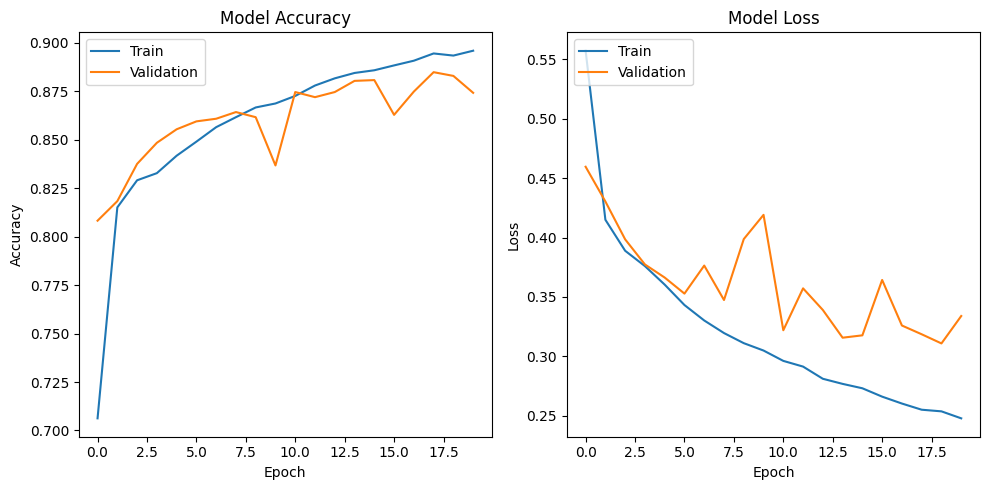

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()



In [14]:
model.save('new.h5')

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
test = ['i feel excited about my doctor appointment today']
classes = ['positive', 'negative']

def predict(text):
    test_seq = tokenizer.texts_to_sequences(text)
    pad_test = pad_sequences(test_seq, maxlen=max_sequence_length, padding='post')
    model_prediction = model.predict(pad_test)
    prediction = classes[np.argmax(model_prediction)]
    return prediction

# prediction = model.predict(pad_test)
# df.sentiment.unique()[np.argmax(prediction)]

In [17]:
model = tf.keras.models.load_model('new.h5')

model.predict(pad_test)

1/1 [==============================] - 1s 653ms/step


array([[0.10293787, 0.8970621 ]], dtype=float32)

In [45]:
import requests
def all_articles():
    global articles
    api = 'b456a0b678604587bd37dfe28a0bf520'

    base_url = 'https://newsapi.org/v2/everything'

    params = {
        'source': 'bbc-news',
        'q': 'world',
        'sortBy': 'publishedAt',
        'apiKey': api
    }

    gathered_articles = requests.get(base_url, params=params)

    data = gathered_articles.json()

    articles = data['articles']

    return articles

all_articles()
ls=[]
for i in range(len(df)):
    ls.append(predict([df.review[i]]))

1/1 [==============================] - 0s 37ms/step


In [77]:
from collections import Counter

pred = Counter(ls)
pred = pd.DataFrame(list(pred.items()))
pred.columns = ['a','b']
pred.set_index('a',inplace=True)

In [81]:
pred.value_counts()

b    
18629    1
31371    1
Name: count, dtype: int64

In [80]:
true

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [79]:
true = df.sentiment.value_counts()

from sklearn.metrics import accuracy_score

accuracy_score(true,pred)

0.0